In [1]:
import abtem
import ase
import matplotlib.pyplot as plt
import numpy as np
from abtem.finite_difference import DivergedError
from abtem.multislice import MultisliceTransform

abtem.config.set({"device": "cpu"})
abtem.config.set({"local_diagnostics.progress_bar": True})
abtem.config.set({"local_diagnostics.task_level_progress": False})

# Multislice using the real space algorithm

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': '(110)'}, xlabel='x [Å]', ylabel='y [Å]'>)

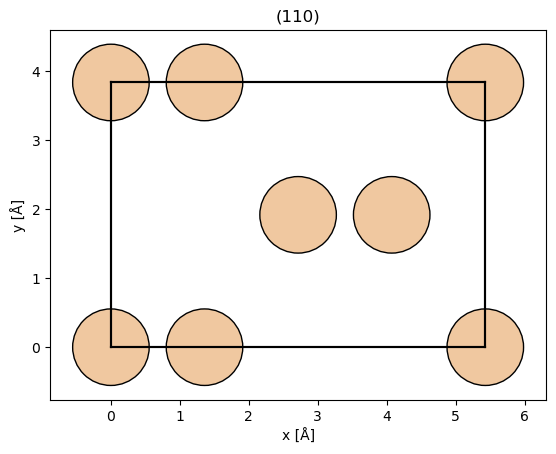

In [2]:
desired_rotation = 45
silicon = ase.build.bulk("Si", cubic=False)

# Rotates silicon structure by 45 degrees.
rotated_silicon = silicon.copy()

rotated_silicon.rotate(desired_rotation, "x", rotate_cell=True)
rotated_silicon, transform = abtem.orthogonalize_cell(
    rotated_silicon, max_repetitions=10, return_transform=True
)

rotated_silicon.center(axis=2)

abtem.show_atoms(
    rotated_silicon, show_periodic=True, scale=0.5, title="(110)", plane="xy"
)

Create a potential.

In [3]:
potential_unit = abtem.Potential(
    rotated_silicon,
    slice_thickness=0.5,
    sampling=0.05,
    projection="finite",
)
potential = abtem.CrystalPotential(potential_unit, repetitions=(1, 1, 10))
plane_wave = abtem.PlaneWave(energy=200e3)
plane_wave.grid.match(potential)

Simulations currently requires importing the `MultisliceTransform` object. You can set the order of the accuracy of the [finite difference derivative stencil](https://en.wikipedia.org/wiki/Finite_difference_coefficient) using the `derivative_accuracy` keyword. The total number of terms in the series expansion is determined by a convergence criteria.

The actual FD stencil can be obtained as below, we set `derivative=2` to get the second derivative.

In [4]:
from abtem.finite_difference import finite_difference_coefficients
#accuracies = [2, 4, 6, 8, 10, 12, 14, 16, 18]
#{accuracy:list(finite_difference_coefficients(accuracy=accuracy, derivative=2)) for accuracy in accuracies}

In [5]:
transform = MultisliceTransform(potential, method="realspace", derivative_accuracy=8)
exit_wave_rms = plane_wave.build().apply_transform(transform).compute()

transform = MultisliceTransform(potential, method="conventional")
exit_wave_cms = plane_wave.build().apply_transform(transform).compute()

[########################################] | 100% Completed | 2.46 ss
[########################################] | 100% Completed | 507.85 ms


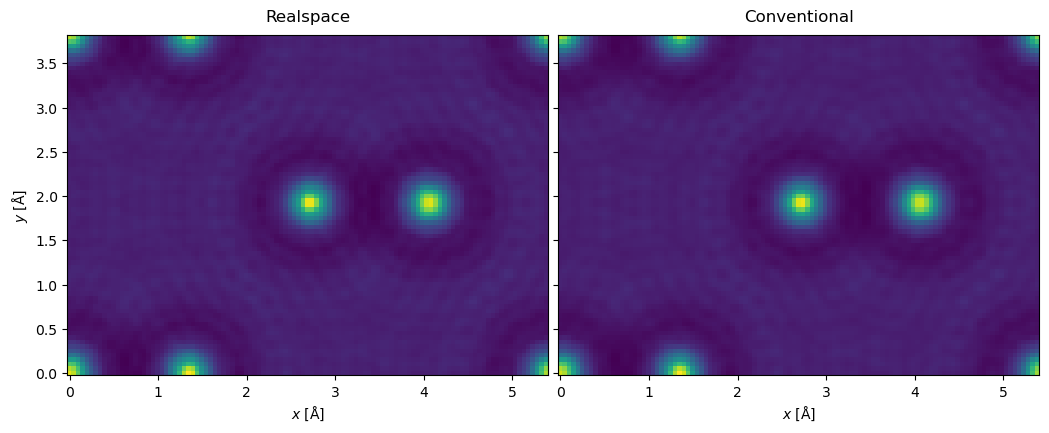

In [6]:
abtem.stack((exit_wave_rms, exit_wave_cms), ("Realspace", "Conventional")).show(
    explode=True, figsize=(12, 4)
)

The calculation may diverge if the slices are too thick, you can catch the `DivergedError` exception. A better sampling also requires a smaller slice thickness.

In [7]:
potential_unit = abtem.Potential(
    rotated_silicon,
    slice_thickness=2,
    sampling=0.05,
    projection="finite",
)

potential = abtem.CrystalPotential(potential_unit, repetitions=(1, 1, 10))
plane_wave = abtem.PlaneWave(energy=200e3)
plane_wave.grid.match(potential)

try:
    transform = MultisliceTransform(
        potential, method="realspace", derivative_accuracy=8
    )
    exit_wave_rms = plane_wave.build().apply_transform(transform).compute()
except DivergedError:
    print("calculation diverged")

[                                        ] | 0% Completed | 757.57 ms
calculation diverged
